
# Objetivo 2: Generación de modelos

Pipeline completo para la predicción del crecimiento de datos de biodiversidad en GBIF.

Este script implementa el flujo de trabajo de principio a fin para modelar datos de panel
de series temporales, incluyendo:
1.  Carga datos de PA_dataAnalysis y preparación
2.  Ingeniería de características temporales (lags y ventanas móviles).
3.  Un marco de validación cruzada robusto para series de tiempo (ventana expansiva).
4.  Preprocesamiento (imputación y escalado) dentro del bucle de validación para evitar fuga de datos.
5.  Entrenamiento y evaluación comparativa de cuatro modelos:
    - Prophet.
    - Random Forest.
    - XGBoost.
    - Red Neuronal LSTM (para modelado secuencial).

6.  Selección del mejor modelo basado en métricas de rendimiento (MAE, RMSE, R²).
7.  Reentrenamiento del modelo final y generación de pronósticos para Colombia hasta 2030
    bajo dos escenarios de políticas.

In [18]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

# Preprocesamiento y modelado de Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split


# Modelos especializados

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Modelado de Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Configuraciones generales
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

In [19]:
# =============================================================================
# 2. CARGA Y PREPARACIÓN DE DATOS
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
Data_final = pd.read_csv(url)

Data_final['ds'] = pd.to_datetime(Data_final['year'], format='%Y')
Data_final = Data_final.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
Data_final[TARGET] = np.log1p(Data_final[TARGET])
print("Transformación log1p aplicada al target.")

columns_to_drop = ['Overall score', 'areas_protegidas', 'countryCode']
Data_final = Data_final.drop(columns=columns_to_drop)

features_total = ['country', 'year', 'ds', 'superficie_total_km2', 'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'Overall score', 'region', 'incomeLevel', 'occurrenceCount_publisher', 'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3']

Transformación log1p aplicada al target.


Para aplicar modelos como Random Forest y XGBoost, es necesario agregar características de temporalidad en los datos, para lo cuál es necesario calcular retardos, que se deben aplicar teniendo en cuenta un análisis del ACF Y PACF, así como la incorporación de los tiempos del retardo como hiperparámetros. 

Los modelos basados en árboles como Random Forest y XGBoost no son conscientes de la secuencia temporal de los datos y no pueden "extrapolar" tendencias más allá de los valores que han visto en el entrenamiento. Por lo tanto, es necesario convertir la información temporal en características que el modelo pueda entender. La creación de retardos (lags) y estadísticas de ventana móvil es la técnica estándar para lograrlo. Se podría identificar el número de retardos como un hiperparámetro, guiado por análisis de ACF y PACF (Ver EDA)

In [20]:
# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS TEMPORALES
# =============================================================================
def create_temporal_features_optimized(data, features_to_lag, lags=[], roll_windows=[]):
    df_copy = data.copy()
    for feature in features_to_lag:
        for lag in lags:
            df_copy[f'{feature}_lag{lag}'] = df_copy.groupby('country')[feature].shift(lag)
        for w in roll_windows:
            df_copy[f'{feature}_rollmean{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).mean()
            df_copy[f'{feature}_rollstd{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).std()
    return df_copy

features_to_lag = ['gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'occurrenceCount_publisher', 
                   'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3'
]
df_featured = create_temporal_features_optimized(
    Data_final,
    features_to_lag=features_to_lag,
    lags=[1, 3, 5],
    roll_windows=[1, 3, 5]
)
print("Ingeniería de características completada.")

Ingeniería de características completada.


In [21]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS BASE PARA MODELOS (SIN ESCALADO GLOBAL)
# =============================================================================
# A. RandomForest y XGBoost (modelos tabulares)
features_tabular = [f for f in df_featured.columns if f not in ['ds', 'year', 'country', TARGET]]
X_tab = df_featured[features_tabular].copy()
y_tab = df_featured[TARGET].copy()

# B. LSTM (modelos secuenciales)
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

columnas_a_excluir_lstm = ['country', TARGET, 'ds']
features_lstm = [f for f in features_total if f not in columnas_a_excluir_lstm]
features_lstm = [f for f in features_lstm if f in Data_final.columns]
look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(Data_final, features=features_lstm, target=TARGET, look_back=look_back)

# C. Prophet (modelo de series temporales)
columnas_a_excluir_p = ['country', TARGET, 'ds', 'year']
regressors_prophet = [f for f in features_total if f not in columnas_a_excluir_p]
regressors_prophet = [r for r in regressors_prophet if r in df_featured.columns]
df_prophet_base = df_featured[['ds', TARGET] + regressors_prophet].rename(columns={TARGET: 'y'})







In [22]:
# =============================================================================
# 5. DEFINICIÓN DE HIPERPARÁMETROS Y FUNCIONES DE OPTIMIZACIÓN
# =============================================================================
# (Las funciones de optimización y definición de hiperparámetros no cambian, se mantienen como en el original)
# 🌲 Random Forest (Mayor rango de complejidad y submuestreo)
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None], # Más profundidad
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt'] # Submuestreo de features
}

# 🚀 XGBoost (Añadir regularización L1/L2 y submuestreo por columna)
xgb_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5], # Parámetro de regularización
    "reg_alpha": [0, 0.005, 0.1] # Regularización L1
}

# 🧠 LSTM (Añadir activación, más unidades y control de learning rate)
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "learning_rate": 0.005, "lstm_activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.001, "lstm_activation": "tanh"},
    {"units": 100, "dropout": 0.4, "epochs": 40, "batch_size": 64, "learning_rate": 0.01, "lstm_activation": "relu"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.005, "lstm_activation": "tanh"}
]

# 📈 Prophet (Mayor rango de prioridades y modo de estacionalidad)
prophet_param_grid = [
    {"changepoint_prior_scale": 0.005, "seasonality_prior_scale": 2, "seasonality_mode": 'additive'},
    {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 10, "seasonality_mode": 'multiplicative'},
    {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 20, "seasonality_mode": 'additive'}
]


def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    # n_iter aumentado de 3 a 5 para mejor exploración
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_

def optimize_xgboost(X_train, y_train, param_grid=xgb_param_grid):
    # Simplificado para velocidad, se puede usar GridSearchCV o RandomizedSearchCV
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    return model
    
def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    # Añadir Early Stopping para mejor entrenamiento
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)

    # Dividir el training set para validación interna de Early Stopping (¡CRÍTICO!)
    # Esto asume que train_test_split ha sido importado.
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)
    
    for params in param_grid:
        model = Sequential([
            # CAMBIO CLAVE: Usar params["lstm_activation"]
            LSTM(params["units"], activation=params["lstm_activation"], input_shape=(look_back, X_train.shape[2])), 
            Dropout(params["dropout"]), 
            # Capa Dense final sin activación (lineal) para regresión
            Dense(1) 
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_train_val, y_train_val, 
                  epochs=params["epochs"], 
                  batch_size=params["batch_size"], 
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[es])
        
        preds = model.predict(X_val, verbose=0).flatten()
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_mae: best_mae, best_model = mae, model
    return best_model

def optimize_prophet(train_df, regressors, param_grid=prophet_param_grid):
    best_model, best_mae = None, float("inf")
    for params in param_grid:
        # CORRECCIÓN: Separar los parámetros básicos de los parámetros adicionales (seasonality_mode)
        prophet_init_params = {k: v for k, v in params.items() if k not in ['seasonality_mode']}
        m = Prophet(yearly_seasonality=True, daily_seasonality=False, **prophet_init_params)
        
        # Añadir modo de estacionalidad
        if 'seasonality_mode' in params:
            m.seasonality_mode = params['seasonality_mode']
            
        for r in regressors:
            m.add_regressor(r)
        
        m.fit(train_df)
        forecast = m.predict(train_df)
        mae = mean_absolute_error(train_df["y"], forecast["yhat"])
        if mae < best_mae: best_mae, best_model = mae, m
    return best_model

In [23]:
# =============================================================================
# 6. MÉTRICAS
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true, y_pred):
    # CORRECCIÓN 3: Revertir la transformación log1p
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }


In [24]:
# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (AJUSTADO PARA EVITAR DATA LEAKAGE)
# =============================================================================
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
unique_years = sorted(df_featured['year'].unique())
results_detailed = {"Prophet": [], "RandomForest": [], "XGBoost": [], "LSTM": []}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")

    # --- Preprocesamiento DENTRO del bucle para evitar fuga de datos ---
    
    # --- A. Modelos Tabulares (RF/XGB) ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]

    # 1. Imputación (ajustar solo en train)
    imputer = IterativeImputer(
    random_state=42, 
    # Usar Random Forest como estimador interno para manejar NaNs en las features
    estimator=RandomForestRegressor(random_state=42) 
    ) 
    X_train_tab_imp = imputer.fit_transform(X_train_tab)
    X_test_tab_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado (ajustar solo en train)
    scaler_tab = StandardScaler()
    X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab_imp)
    X_test_tab_scaled = scaler_tab.transform(X_test_tab_imp)
    
    # --- RandomForest ---
    rf_model = optimize_random_forest(X_train_tab_scaled, y_train_tab)
    y_pred_rf = rf_model.predict(X_test_tab_scaled)
    metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
    results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1})

    # --- XGBoost ---
    xgb_model = optimize_xgboost(X_train_tab_scaled, y_train_tab)
    y_pred_xgb = xgb_model.predict(X_test_tab_scaled)
    metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
    results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1})

    # --- B. LSTM ---
    train_years_fold = df_featured.iloc[train_idx]['year'].unique()
    test_years_fold = df_featured.iloc[test_idx]['year'].unique()
    
    mask_train_lstm = np.isin(years_seq, train_years_fold)
    mask_test_lstm = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train_lstm], y_seq[mask_train_lstm]
    X_test_lstm, y_test_lstm = X_seq[mask_test_lstm], y_seq[mask_test_lstm]

    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        # Escalado para LSTM (ajustar solo en train)
        scaler_lstm = StandardScaler()
        # Aplanar para ajustar el scaler
        X_train_lstm_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
        scaler_lstm.fit(X_train_lstm_flat)
        # Transformar y redimensionar
        X_train_lstm_scaled = scaler_lstm.transform(X_train_lstm_flat).reshape(X_train_lstm.shape)
        X_test_lstm_flat = X_test_lstm.reshape(-1, X_test_lstm.shape[2])
        X_test_lstm_scaled = scaler_lstm.transform(X_test_lstm_flat).reshape(X_test_lstm.shape)
        
        # CORRECCIÓN 2a: ESCALADO DE LA VARIABLE OBJETIVO (Y)
        scaler_y_lstm = StandardScaler()
        y_train_lstm_scaled = scaler_y_lstm.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
        # y_test_lstm NO se escala, ya que se usará su versión sin escalar (con log1p) en compute_metrics
        
        lstm_model = optimize_lstm(X_train_lstm_scaled, y_train_lstm_scaled, look_back)
        
        # Predicción en el rango escalado
        y_pred_lstm_scaled = lstm_model.predict(X_test_lstm_scaled, verbose=0).flatten()
        
        # CORRECCIÓN 2b: DESESCALADO DE LA PREDICCIÓN
        y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()

        # El y_test_lstm contiene los valores REALES con la transformación log1p aplicada.
        # Las métricas se calculan correctamente en la función compute_metrics desescalando ambos.
        metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
        results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1})

    # --- C. Prophet ---
    prophet_train = df_prophet_base.iloc[train_idx]
    prophet_test = df_prophet_base.iloc[test_idx]
    
    if not prophet_train.empty and not prophet_test.empty and regressors_prophet:
        # Escalar regresores para Prophet
        scaler_prophet = StandardScaler()
        prophet_train[regressors_prophet] = scaler_prophet.fit_transform(prophet_train[regressors_prophet])
        prophet_test[regressors_prophet] = scaler_prophet.transform(prophet_test[regressors_prophet])
        
        try:
            prophet_model = optimize_prophet(prophet_train, regressors_prophet)
            forecast = prophet_model.predict(prophet_test.drop(columns='y'))
            metrics_prophet = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            results_detailed["Prophet"].append({**metrics_prophet, "fold": fold + 1})
        except Exception as e:
            print(f"⚠️ Prophet falló en fold {fold+1}: {e}")


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2025-10-30 20:31:30.057919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:30.240481: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:31:32.863078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:39.430830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:39.847472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:31:48.362474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:48.533285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:31:50.253492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:56.008708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:31:56.350060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] done processing
20:32:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:01 - cmdstanpy - INFO - Chain [1] done processing
20:32:01 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing
20:32:02 - cmdstanpy - INFO - Chain [1] start processing
20:32:02 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 1/5 [02:13<08:52, 133.24s/it]


===== FOLD 2/5 =====


2025-10-30 20:35:22.154061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:22.321258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:35:24.494187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:30.778575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:31.103839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:35:36.430303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:36.600912: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:35:37.923012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:40.230210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:35:40.543823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:45 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:45 - cmdstanpy - INFO - Chain [1] done processing
20:35:45 - cmdstanpy - INFO - Chain [1] start processing
20:35:46 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 2/5 [05:57<09:19, 186.52s/it]


===== FOLD 3/5 =====


2025-10-30 20:39:37.232890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:37.394186: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:39:39.612013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:45.940502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:46.273015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:39:51.003116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:51.169315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:39:52.572223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:58.104828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:39:58.482982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 4/5 =====


2025-10-30 20:43:43.019681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:43:43.194194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:43:45.532038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:07.324549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:07.731419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:44:12.724157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:12.883431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:44:14.269676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:19.339766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:44:19.665794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2025-10-30 20:49:08.790978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:08.968227: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:49:11.231161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:17.538521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:17.869107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-10-30 20:49:22.805646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:22.967850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-10-30 20:49:24.372536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:29.475858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-30 20:49:29.812004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


Resultados detallados por fold:
           model           MAE          RMSE            R2          MAPE  \
0        Prophet  1.212328e+08  2.968836e+08 -3.874500e+02  8.710941e+16   
1        Prophet  2.272265e+08  7.277893e+08 -8.844703e+02  6.478151e+17   
2        Prophet  1.100282e+07  2.132964e+07 -4.699877e-01  2.156060e+14   
3        Prophet  5.729076e+06  1.156148e+07 -2.122310e-01  6.982010e+15   
4        Prophet  1.356043e+12  6.770491e+12 -2.301727e+09  7.044751e+21   
5   RandomForest  3.146116e+06  6.347620e+06  8.224239e-01  2.672822e+14   
6   RandomForest  2.938570e+06  7.645166e+06  9.022906e-01  2.088752e+11   
7   RandomForest  1.599550e+06  3.581453e+06  9.585556e-01  8.913817e+12   
8   RandomForest  1.150783e+06  2.176772e+06  9.570281e-01  1.606621e+12   
9   RandomForest  3.826565e+07  1.265714e+08  1.955762e-01  7.292403e+10   
10       XGBoost  3.983590e+06  7.227074e+06  7.698094e-01  3.256257e+14   
11       XGBoost  4.139983e+06  1.036850e+07  8.202808e

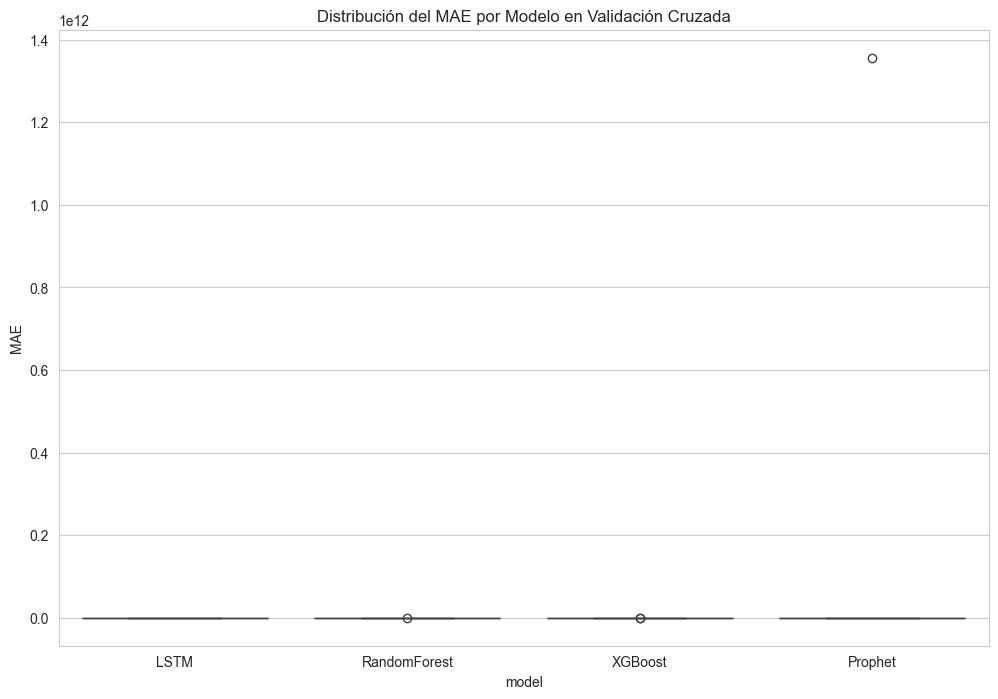

In [26]:
# =============================================================================
# 8. RESUMEN DE RESULTADOS
# =============================================================================
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    print("\nResultados detallados por fold:")
    print(df_results)
    print("\nResumen por modelo (media de métricas):")
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print(summary)

    # Visualización
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df_results, x='model', y='MAE', order=summary.index)
    plt.title('Distribución del MAE por Modelo en Validación Cruzada')
    plt.show()
else:
    print("No se generaron resultados para analizar.")



🚀 Iniciando pipeline de Prophet a nivel de país...


Procesando países:   0%|          | 0/41 [00:00<?, ?it/s]06:43:53 - cmdstanpy - INFO - Chain [1] start processing
06:43:53 - cmdstanpy - INFO - Chain [1] done processing
06:43:53 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:54 - cmdstanpy - INFO - Chain [1] done processing
Procesando países:   2%|▏         | 1/41 [00:01<01:08,  1.70s/it]06:43:54 - cmdstanpy - INFO - Chain [1] start processing
06:43:55 - cmdstanpy - INFO - Chain [1] done processing
06:43:55 - cmdstanpy - INFO - Chain [1] start processing
06:43:56 - cmdstanpy - INFO - Chain [1] done processing
06:43:56 - cmdstanpy - INFO - Chain [1] start processing
06:43:56 - cmdstanpy - INFO - 



📊 Resumen de Rendimiento de Prophet por País (media de métricas):
                                    MAE          RMSE            R2
country                                                            
Uruguay                    2.385975e+05  2.491807e+05 -7.946933e+00
Iceland                    6.768195e+09  6.889830e+09 -4.801731e+01
United States              1.664924e+08  1.765385e+08 -6.647209e+01
Switzerland                3.452511e+06  3.999123e+06 -7.729538e+02
Netherlands                5.205155e+07  5.468609e+07 -7.823272e+02
Guinea                     1.362457e+06  1.916598e+06 -8.655060e+02
Canada                     1.098663e+08  1.274439e+08 -9.142173e+02
Belgium                    1.867758e+07  2.166785e+07 -1.174448e+03
Mauritania                 3.100437e+04  3.947422e+04 -2.379231e+03
Denmark                    1.640483e+07  1.675066e+07 -1.711351e+04
Argentina                  1.058729e+07  1.200750e+07 -1.887690e+04
Peru                       6.781061e+06  6.84416

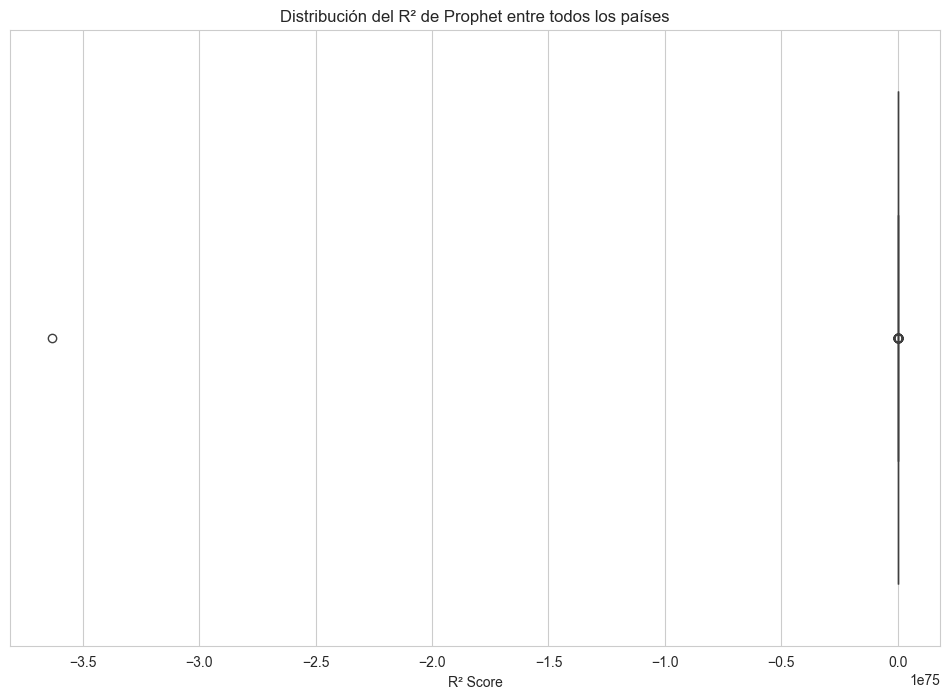

In [56]:
# =============================================================================
# PRUEBA DEL MODELO PROPHET A NIVEL DE PAÍS
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')

# ASUMIMOS QUE 'df_featured' y 'df_prophet_base' YA EXISTEN DEL SCRIPT ANTERIOR

# Funciones de métricas y optimización de Prophet
def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask): return 0.0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, eps=1e-8):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

def compute_metrics(y_true, y_pred):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }

def optimize_prophet_country(train_df, regressors):
    # Usamos una configuración estándar para Prophet, ya que la optimización es costosa por país.
    # Se puede expandir con un grid de hiperparámetros si es necesario.
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    if regressors:
        for r in regressors:
            m.add_regressor(r)
    m.fit(train_df)
    return m

# =============================================================================
# PIPELINE DE PROPHET POR PAÍS CON VALIDACIÓN CRUZADA
# =============================================================================
print("🚀 Iniciando pipeline de Prophet a nivel de país...")

n_splits = 5 # Usaremos 5 pliegues, pero ajustado a series más cortas
unique_countries = df_featured['country'].unique()
all_country_results = []
regressors_prophet = [r for r in df_prophet_base.columns if r not in ['ds', 'y']]


# Bucle exterior: Itera sobre cada país
for country in tqdm(unique_countries, desc="Procesando países"):
    
    df_country = df_prophet_base[df_featured['country'] == country].copy().reset_index(drop=True)
    
    # Se necesita un mínimo de datos para una validación cruzada de 5 pliegues
    if len(df_country) < n_splits + 1:
        print(f"⚠️  Saltando {country}: datos insuficientes ({len(df_country)} registros).")
        continue

    # Bucle interior: Validación cruzada para el país actual
    tscv_country = TimeSeriesSplit(n_splits=n_splits)
    for fold, (train_idx, test_idx) in enumerate(tscv_country.split(df_country)):
        
        # 1. División de datos para el fold actual
        prophet_train = df_country.iloc[train_idx]
        prophet_test = df_country.iloc[test_idx]

        if prophet_train.empty or prophet_test.empty:
            continue

        # 2. Preprocesamiento (Escalado de regresores) DENTRO del fold
        if regressors_prophet:
            scaler = StandardScaler()
            prophet_train[regressors_prophet] = scaler.fit_transform(prophet_train[regressors_prophet])
            prophet_test[regressors_prophet] = scaler.transform(prophet_test[regressors_prophet])
        
        # 3. Entrenamiento del modelo
        try:
            model = optimize_prophet_country(prophet_train, regressors_prophet)
            
            # 4. Predicción
            future_df = model.make_future_dataframe(periods=0) # Usamos solo las fechas de test
            future_df = prophet_test.drop(columns='y')
            forecast = model.predict(future_df)
            
            # 5. Evaluación
            metrics = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            metrics['country'] = country
            metrics['fold'] = fold + 1
            all_country_results.append(metrics)
        
        except Exception as e:
            print(f"❌ Error procesando {country} en fold {fold+1}: {e}")


# =============================================================================
# 8. RESUMEN DE RESULTADOS DE PROPHET POR PAÍS
# =============================================================================
if all_country_results:
    df_results_country = pd.DataFrame(all_country_results)

    print("\n\n📊 Resumen de Rendimiento de Prophet por País (media de métricas):")
    summary_country = df_results_country.groupby("country")[["MAE", "RMSE", "R2"]].mean().sort_values("R2", ascending=False)
    print(summary_country)

    print("\n\n📈 Rendimiento Promedio General de Prophet (a través de todos los países):")
    print(summary_country.mean())

    # Visualización de la distribución del R2 entre países
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df_results_country['R2'])
    plt.title('Distribución del R² de Prophet entre todos los países')
    plt.xlabel('R² Score')
    plt.show()
else:
    print("\nNo se generaron resultados para analizar.")

Pendientes: 

    INCLUIR SARIMAX DE TODOS MODOS, INTENTAR HACER UNA TRANSFORMACIÓN LOGARÍTMICA, SE PUEDE PONER SIN LA VALIDACIÓN DE SUPUESTOS. 
    TENER CUIDADO CON EL CROSS VALIDATION - Rehacer formula del MAPE porque los valores no son coherentes
    Aplicar rezagos en bloques. Se deben hacer modelos con diferentes rezagos. Tener en cuenta que se pierden observaciones. Tomar todas las X y rezagar todas y hasta 3 periodos. Si incluir y-1.
    